# HW2 - Amit Parizat & Yoel Melul

## Theory Questions

### Q1
**To evaluate how well our model performs at T1D classification, we need to have evaluation metrics that measures of its performances/accuracy. Which evaluation metric is more important to us: model accuracy or model performance? Give a simple example that illustrates your claim.**

In our model, the more important evaluation metric is model performance. Like we saw in lecture "*C08 - Practical consideration on training a model II*" in slide 8, accuracy could be high even when the classifier misclassifies most of 'Yes' labeled examples. For example, when 99% percent of the data is labeled 'No' and only 1% is labeled 'Yes' (could be our case since most of the population doesn't have diabetes), even when the classifier labeles 'No' all the examples we obtain high accuracy. In this case, performance statistics such as sensitivity, PPV and F1 would be more informative.

### Q2
**T1D is often associated with other comorbidities such as a heart attack. You are asked to design a ML algorithm to predict which patients are going to suffer a heart attack. Relevant patient features for the algorithm may include blood pressure (BP), body-mass index (BMI), age (A), level of physical activity (P), and income (I). You should choose between two classifiers: the first uses only BP and BMI features and the other one uses all of the features available to you. Explain the pros and cons of each choice.**

When using only two features we create a simpler model that requires less computational effort to be made and less memory space to accommodate weights or any other information about the model. However, when not taking into consideration all of the data provided, we may miss important information that may have high indicativity on heart attacks. We may also miss trasformations of the neglected features that could yield valuable new features.

### Q3
**A histologist wants to use machine learning to tell the difference between pancreas biopsies that show signs of T1D and those that do not. She has already come up with dozens of measurements to take, such as color, size, uniformity and cell-count, but she isn’t sure which model to use. The biopsies are really similar, and it is difficult to distinguish them from the human eye, or by just looking at the features. Which of the following is better: logistic regression, linear SVM or nonlinear SVM? Explain your answer.**

The best model of the above for such case is the nonlinear SVM model. Since the current features the histologist has don't have significant correlation with T1D, there might be a nonlinear combination of them that could have a better correlation.

### Q4
**What are the differences between LR and linear SVM and what is the difference in the effect/concept of their hyper-parameters tuning?**

Logistic regression is based on probabilistically separating the data through the sigmoid function, asigning each data point to the class with the highest probability of including it. In contrast, linear SVMs are based on a geometrical separation of the data, finding the hyperplane with the widest margin that will separate data points to several classifications. When tuning hyper-parameters in LR we tune a single parameter $(\lambda)$, while in SVM we tune a set of parameters $(C,\gamma)$, this is why grid search can be computationally expensive.

## Coding Assignment

### Part 1
**Load the data. Explain any preprocessing.**

Import modules

In [1]:
import pandas as pd 
import numpy as np
from pathlib import Path
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from IPython.display import display
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, hinge_loss, plot_confusion_matrix, confusion_matrix, roc_auc_score, plot_roc_curve
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

%load_ext autoreload
random.seed(10)

Load data

In [2]:
file = Path.cwd().joinpath('HW2_data.csv')
dataset = pd.read_csv(file)

Check for nan values

In [3]:
nan_examples = set()
nan_features = set()
for feat in dataset.columns:
    for index in dataset.index:
        if pd.isna(dataset[feat][index]):
            print(feat, index, end=', ')
            nan_examples.add(index)
            nan_features.add(feat)
print('\n\nThere are %.f examples containing nans.' %len(nan_examples))
print('There are %.f features containing nans.' %len(nan_features))

Increased Thirst 521, Increased Thirst 522, Increased Thirst 523, Increased Thirst 524, Increased Thirst 525, Increased Thirst 526, Increased Thirst 527, Increased Thirst 528, Increased Thirst 529, Increased Thirst 544, Increased Thirst 545, Increased Thirst 546, Increased Thirst 547, Increased Thirst 548, Increased Thirst 549, Increased Thirst 550, Increased Thirst 551, Increased Thirst 552, Increased Thirst 553, Increased Thirst 554, Sudden Weight Loss 521, Sudden Weight Loss 525, Sudden Weight Loss 526, Sudden Weight Loss 527, Sudden Weight Loss 528, Sudden Weight Loss 529, Sudden Weight Loss 530, Sudden Weight Loss 531, Sudden Weight Loss 532, Increased Hunger 530, Increased Hunger 531, Increased Hunger 532, Increased Hunger 533, Increased Hunger 534, Increased Hunger 535, Increased Hunger 536, Increased Hunger 537, Increased Hunger 538, Increased Hunger 539, Increased Hunger 540, Increased Hunger 541, Increased Hunger 542, Genital Thrush 548, Genital Thrush 549, Genital Thrush 550

Drop examples containing  nans

In [4]:
c_dataset = dataset.drop(nan_examples, axis=0)

Change 'Yes' to '1' and 'No' to '0'

In [5]:
c_dataset = c_dataset.rename(columns={'Gender': 'Male'})
c_dataset = c_dataset.replace(to_replace=['No', 'Negative', 'Female', 'Yes', 'Positive', 'Male'], value=[0, 0, 0, 1, 1, 1])

Check the dataset is OK

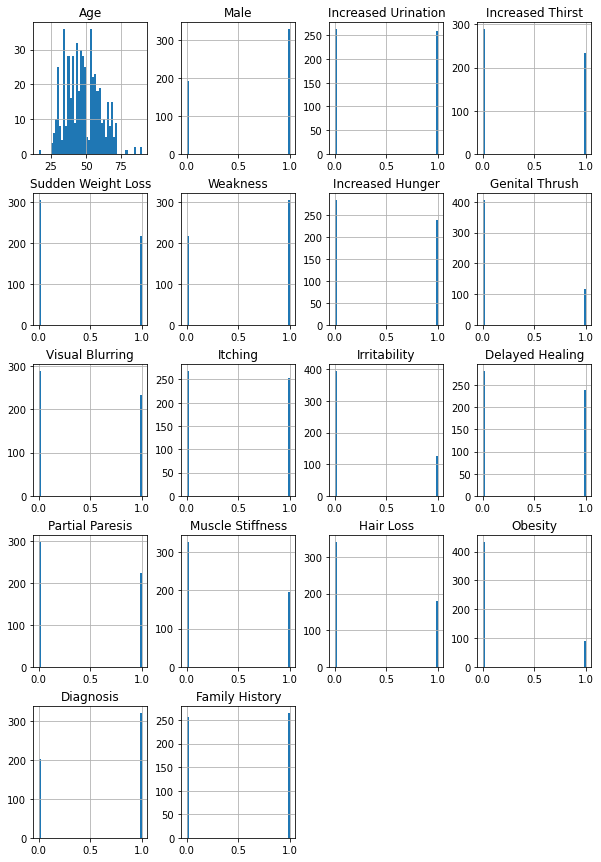

In [6]:
c_dataset.hist(bins=50, figsize=(10, 15))
plt.show()

Split dataset to features and label

In [7]:
feature_list = ['Age', 'Male',
                'Increased Urination', 'Increased Thirst',
                'Sudden Weight Loss', 'Weakness',
                'Increased Hunger', 'Genital Thrush',
                'Visual Blurring', 'Itching', 'Irritability',
                'Delayed Healing', 'Partial Paresis',
                'Muscle Stiffness', 'Hair Loss',
                'Obesity', 'Family History'
               ]
features = c_dataset[feature_list]
label = c_dataset[['Diagnosis']]

### Part 2
**Perform a test-train split of 20% test.**

In [8]:
X_train, x_test, Y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=3, stratify=label)

### Part 3
**Provide a detailed visualization and exploration of the data.**

**a.** We show the distribution of the features is similar between test and train:

In [9]:
distribution_feat = X_train.drop(columns='Age').keys()
distribution_train = X_train.drop(columns='Age').mean()*100
distribution_test = x_test.drop(columns='Age').mean()*100
distribution = {'Positive Feature':distribution_feat, 'Train %':distribution_train, 'Test %':distribution_test, 'Delta %':distribution_train-distribution_test}
distribution_table = pd.DataFrame(distribution)

avg_age = {'Train': X_train['Age'].mean(), 'Test': x_test['Age'].mean()}
avg_age['Delta'] = avg_age['Train'] - avg_age['Test']
distribution_age = pd.DataFrame(avg_age, index=['Average Age'])

diagnosis = {'Train %': Y_train['Diagnosis'].mean()*100, 'Test %': y_test['Diagnosis'].mean()*100}
diagnosis['Delta %'] = diagnosis['Train %'] - diagnosis['Test %']
distribution_diagnosis = pd.DataFrame(diagnosis, index=['Diagnosis'])

display(distribution_diagnosis)
display(distribution_age)
display(distribution_table.style.hide_index())

#sum(abs(distribution_table['Delta %']))

,Train %,Test %,Delta %
Diagnosis,61.483254,60.952381,0.530873


,Train,Test,Delta
Average Age,47.760766,49.095238,-1.334473


Positive Feature,Train %,Test %,Delta %
Male,62.918660,63.809524,-0.890864
Increased Urination,50.000000,47.619048,2.380952
Increased Thirst,45.215311,41.904762,3.310549
Sudden Weight Loss,42.344498,38.095238,4.249260
Weakness,58.133971,60.000000,-1.866029
Increased Hunger,46.411483,41.904762,4.506721
Genital Thrush,21.770335,23.809524,-2.039189
Visual Blurring,43.779904,47.619048,-3.839143
Itching,47.846890,51.428571,-3.581681
Irritability,24.401914,23.809524,0.592390


**i. What issues could an imbalance of features between train and test cause?**

Imbalance of features between train and test sets could cause overfitting.

**ii. How could you solve the issue?**

This issue could be solved by stratification.

**b.** We show the relationship between feature and label:

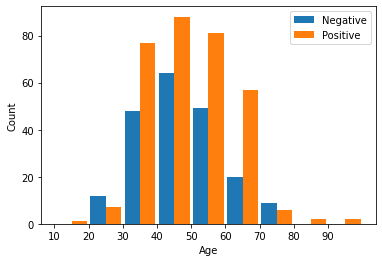

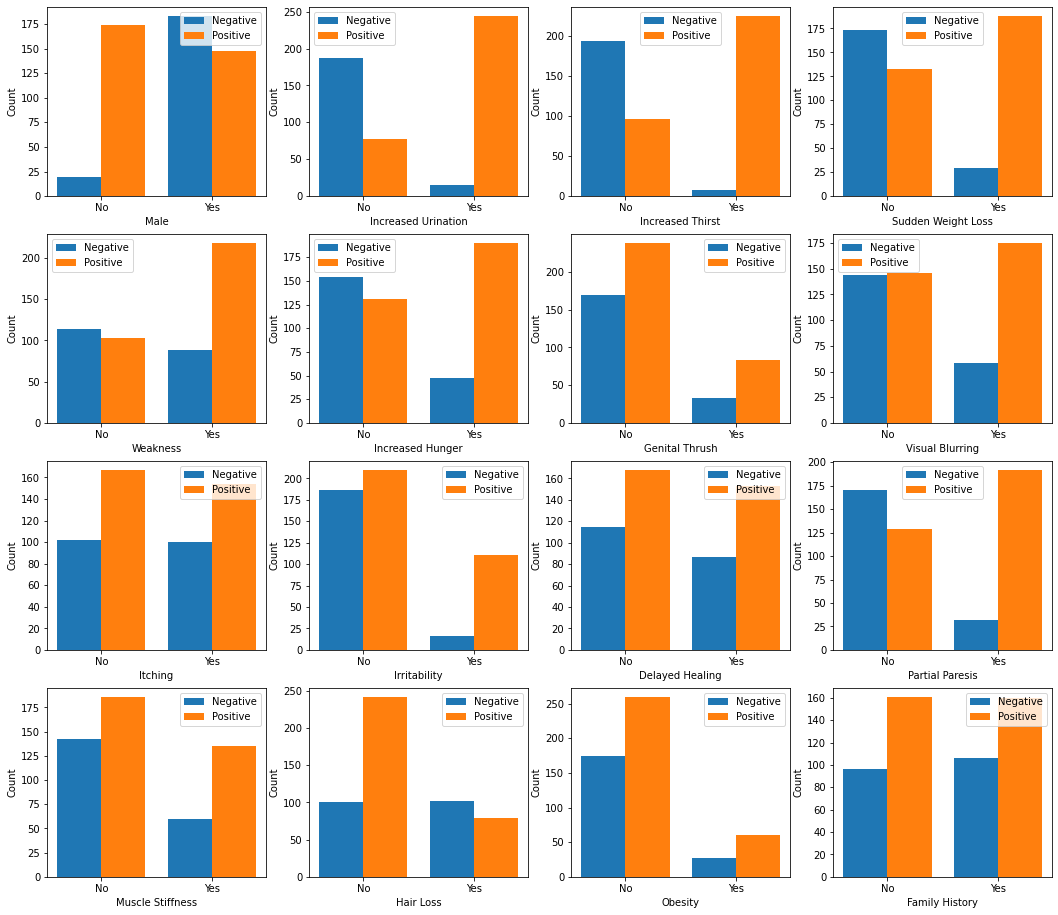

In [10]:
w = 0.4
w2 = 4.5

age_label0= np.zeros(9)
age_label1= np.zeros(9)

# Plot how many positives/negatives are in each 10 year range
for j in range(9):
    age_label0[j] = sum(features['Age'][i]>=10*(j+1) and features['Age'][i]<(10+10*(j+1)) and label.loc[i]==0 for i in features.index).item()
    age_label1[j] = sum(features['Age'][i]>=10*(j+1) and features['Age'][i]<(10+10*(j+1)) and label.loc[i]==1 for i in features.index).item()

plt.bar([15,25,35,45,55,65,75,85,95], age_label0, w2, label='Negative')
plt.bar([15,25,35,45,55,65,75,85,95] + np.repeat(w2,9), age_label1, w2, label='Positive')
plt.xlabel('Age')
plt.ylabel('Count')
plt.xticks([10,20,30,40,50,60,70,80,90]+ np.repeat(w2/2,9),[10,20,30,40,50,60,70,80,90])
plt.legend()
plt.show()

fig = plt.figure(figsize = [18,16])
for feat in features.drop(columns='Age').columns:
    feat0_label0 = sum([features[feat][i]==0 and label.loc[i]==0 for i in features.index]).item()
    feat0_label1 = sum([features[feat][i]==0 and label.loc[i]==1 for i in features.index]).item()
    feat1_label0 = sum([features[feat][i]==1 and label.loc[i]==0 for i in features.index]).item()
    feat1_label1 = sum([features[feat][i]==1 and label.loc[i]==1 for i in features.index]).item()
    
    ax = fig.add_subplot(4,4,features.columns.get_loc(feat))
    ax.bar([0, 1], [feat0_label0, feat1_label0], w, label='Negative')
    ax.bar([w, 1+w], [feat0_label1, feat1_label1], w, label='Positive')
    ax.set_xlabel(feat)
    ax.set_ylabel('Count')
    ax.set_xticks([w/2,1+w/2])
    ax.set_xticklabels(['No','Yes'])
    ax.legend()


**c.** Additional plots:

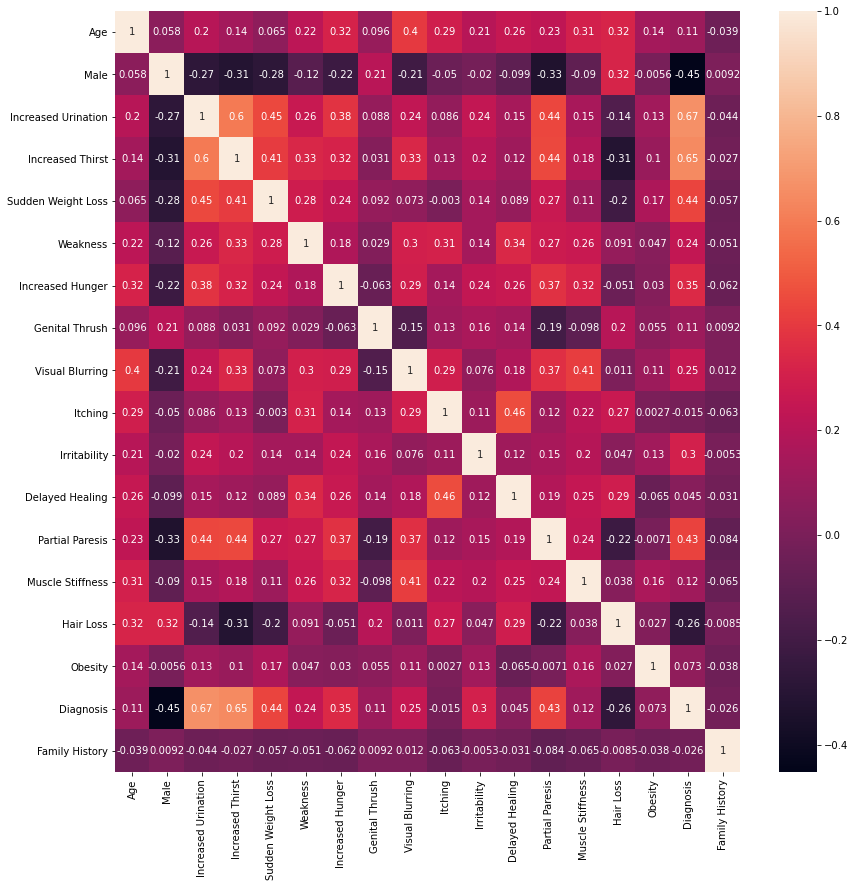

In [11]:
plt.figure(figsize = (14,14))
sns.heatmap(c_dataset.corr(), annot = True)
plt.show()

**d.** Insights:

### Part 4
**Encode all your data as one hot vectors.**

This process was done in *Part 1* except for 'Age' feature since there are many values available for this feature. We will only scale this feature:

In [12]:
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled['Age'] = scaler.fit_transform(X_train['Age'].values.reshape(-1, 1))
x_test['Age'] = scaler.transform(x_test['Age'].values.reshape(-1, 1))

/Users/yoelmelul/opt/anaconda3/envs/bm-336546/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
X_train_scaled = X_train_scaled.values
x_test = x_test.values
Y_train = Y_train.values
y_test = y_test.values

### Part 5
**Choose, build and optimize Machine Learning Models.**

In [14]:
calc_TN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 0]
calc_FP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[0, 1]
calc_FN = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 0]
calc_TP = lambda y_true, y_pred: confusion_matrix(y_true, y_pred)[1, 1]

def print_stats(model, x_test, y_test):
    """
    print performance staistics and plot confusion matrix
    inputs: ML model, test set features and models
    """
    y_pred_test = model.predict(x_test)
    y_pred_proba_test = model.predict_proba(x_test)
    plot_confusion_matrix(model, x_test, y_test, cmap=plt.cm.Blues)
    plt.grid(False)
    
    TN = calc_TN(y_test, y_pred_test)
    FP = calc_FP(y_test, y_pred_test)
    FN = calc_FN(y_test, y_pred_test)
    TP = calc_TP(y_test, y_pred_test)
    PPV = TP / (TP + FP)
    SE = TP / (TP + FN)
    
    print('Sensitivity is: %.2f' %SE, end=', ')
    print('Specificity is: %.2f' %(TN / (TN + FP)), end=', ')
    print('PPV is: %.2f' %PPV, end=', ')
    print('NPV is: %.2f' %(TN / (TN + FN)), end=', ')
    print('Accuracy is: %.2f' %((TN + TP) / (TN + FN + TP + FP)), end=', ')
    print('F1 is: %.2f' %(2 * PPV * SE / (PPV + SE)), end=', ')
    print('AUROC is {:.3f}'.format(roc_auc_score(y_test, y_pred_proba_test[:,1])))
    
def return_stats(model, x_test, y_test):
    y_pred_test = model.predict(x_test)
    y_pred_proba_test = model.predict_proba(x_test)
    loss = log_loss
    TN = calc_TN(y_test, y_pred_test)
    FP = calc_FP(y_test, y_pred_test)
    FN = calc_FN(y_test, y_pred_test)
    TP = calc_TP(y_test, y_pred_test)
    PPV = TP / (TP + FP)
    SE = TP / (TP + FN)
    SP = TN / (TN + FP)
    ACC = (TN + TP) / (TN + FN + TP + FP)
    F1 = 2 * PPV * SE / (PPV + SE)
    AUROC = roc_auc_score(y_test, y_pred_proba_test[:,1])
    logloss = log_loss(y_test, y_pred_proba_test)
    hinge_y_test = np.array([2*i-1 for i in y_test])
    hinge_y_pred_test = np.array([2*i-1 for i in y_pred_test])
    hingeloss = hinge_loss(hinge_y_test, hinge_y_pred_test)
    return {'Log Loss': logloss, 'Hinge Loss': hingeloss,'Sensitiviy': SE, 'Specificity': SP, 'Accuracy': ACC, 'F1': F1, 'AUROC': AUROC}

First, we will train a linear model with no regularization.

Train loss is 0.17827
Test loss is 0.22375
The classifier achieved an accuracy of 94.50% on training set.
The classifier achieved an accuracy of 90.48% on testing set.
Sensitivity is: 0.89, Specificity is: 0.93, PPV is: 0.95, NPV is: 0.84, Accuracy is: 0.90, F1 is: 0.92, AUROC is 0.970


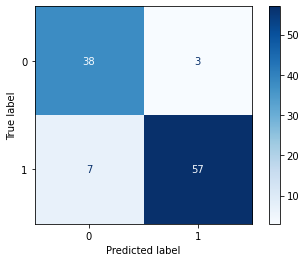

In [15]:
lr = LogisticRegression(random_state=5, max_iter=2000, solver='lbfgs')
lr.fit(X_train_scaled, Y_train.ravel())

print('Train loss is %.5f' %log_loss(Y_train, lr.predict_proba(X_train_scaled)) )
print('Test loss is %.5f' %log_loss(y_test, lr.predict_proba(x_test)) )
print('The classifier achieved an accuracy of %.2f%% on training set.' %(100*lr.score(X_train_scaled, Y_train)))
print('The classifier achieved an accuracy of %.2f%% on testing set.' %(100*lr.score(x_test, y_test)))
print_stats(lr, x_test, y_test)

We train a second linear model, this time with regulation.

In [16]:
x_train_orig, x_val_orig, y_train, y_val= train_test_split(X_train, Y_train, test_size = 0.2, random_state = 10, stratify=Y_train)

In [17]:
scaler = StandardScaler()
x_train = x_train_orig.copy()
x_val = x_val_orig.copy()
x_train['Age'] = scaler.fit_transform(x_train_orig['Age'].values.reshape(-1, 1))
x_val['Age'] = scaler.transform(x_val_orig['Age'].values.reshape(-1, 1))

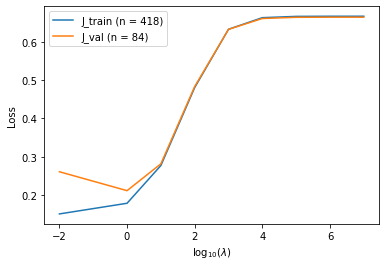

In [18]:
lmbda = np.array([0.01, 1, 10, 100, 1000, 1e04, 1e05, 1e06, 1e07])
J_train = np.zeros_like(lmbda)
J_val = np.zeros_like(lmbda)
for idx, lb in enumerate(lmbda):
    log_reg = LogisticRegression(random_state=5, max_iter=2000, solver='lbfgs', C=1/lb)
    log_reg.fit(x_train, y_train.ravel())
    J_train[idx] = log_loss(y_train, log_reg.predict_proba(x_train))
    J_val[idx] = log_loss(y_val, log_reg.predict_proba(x_val))

plt.plot(np.log10(lmbda), J_train)
plt.plot(np.log10(lmbda), J_val)
plt.xlabel('$\log_{10}(\lambda)$')
plt.ylabel('Loss')
plt.legend(['J_train (n = ' + str(X_train.shape[0]) + ')', 'J_val (n = ' + str(x_val.shape[0]) + ')'])
plt.show()

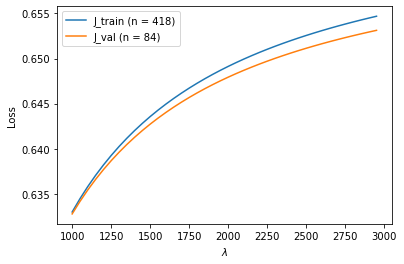

In [19]:
fine_lmbda = np.arange(1000, 3000, 50, dtype=np.float64)
J_train = np.zeros_like(fine_lmbda)
J_val = np.zeros_like(fine_lmbda)
for idx, lb in enumerate(fine_lmbda):
        C = 1/lb
        log_reg = LogisticRegression(random_state=5, max_iter=2000, solver='lbfgs', C=C)
        log_reg.fit(x_train, y_train.ravel())
        J_train[idx] = log_loss(y_train, log_reg.predict_proba(x_train))
        J_val[idx] = log_loss(y_val, log_reg.predict_proba(x_val))
        
plt.plot(fine_lmbda, J_train)
plt.plot(fine_lmbda, J_val)
plt.xlabel('$\lambda$')
plt.ylabel('Loss')
plt.legend(['J_train (n = ' + str(X_train.shape[0]) + ')', 'J_val (n = ' + str(x_val.shape[0]) + ')'])
plt.show()

In [20]:
C = 2000 # best coefficient

Train loss is 0.16110
Validation loss is 0.19627
The classifier achieved an accuracy of 94.02% on training set.
The classifier achieved an accuracy of 90.48% on testing set.
Sensitivity is: 0.91, Specificity is: 0.90, PPV is: 0.94, NPV is: 0.86, Accuracy is: 0.90, F1 is: 0.92, AUROC is 0.977


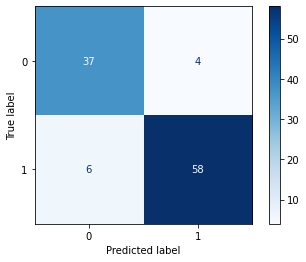

In [21]:
lr_regul = LogisticRegression(random_state=5, max_iter=2000, solver='lbfgs', C=C)
lr_regul.fit(X_train_scaled, Y_train.ravel())

print('Train loss is %.5f' %log_loss(Y_train, lr_regul.predict_proba(X_train_scaled)) )
print('Validation loss is %.5f' %log_loss(y_test, lr_regul.predict_proba(x_test)) )
print('The classifier achieved an accuracy of %.2f%% on training set.' %(100*lr_regul.score(X_train_scaled, Y_train)))
print('The classifier achieved an accuracy of %.2f%% on testing set.' %(100*lr_regul.score(x_test, y_test)))
print_stats(lr_regul, x_test, y_test)

Next we perform 5k cross fold validation with linear, rbf and poly kernels.

In [22]:
skf = StratifiedKFold(n_splits=5, random_state=10, shuffle=True)
svc = SVC(probability=True)
C = np.array([1, 2, 3])
pipe = Pipeline(steps=[('scale', StandardScaler()), ('svm', svc)])
svm = GridSearchCV(estimator=pipe, param_grid={'svm__C': C, 'svm__kernel': ['rbf', 'poly', 'linear'], 'svm__degree': [2, 3]},
                   scoring=['accuracy','f1','precision','recall','roc_auc'], cv=skf,
                   refit='roc_auc', verbose=1, return_train_score=True)
svm.fit(X_train_scaled, Y_train.ravel())
best_svm = svm.best_estimator_
svm.best_params_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


{'svm__C': 1, 'svm__degree': 3, 'svm__kernel': 'poly'}

5k cross validation returned that the best of the models is a polynom of third degree with C=1 .

Sensitivity is: 0.97, Specificity is: 0.98, PPV is: 0.98, NPV is: 0.95, Accuracy is: 0.97, F1 is: 0.98, AUROC is 0.997


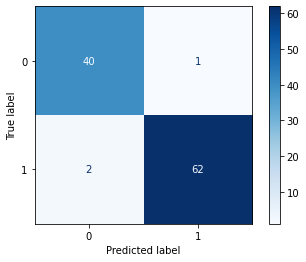

In [23]:
y_pred_test = best_svm.predict(x_test)
y_pred_proba_test = best_svm.predict_proba(x_test)
print_stats(best_svm, x_test, y_test)

The last non-linear model we train is a RandomForestClassifier

Sensitivity is: 0.92, Specificity is: 0.98, PPV is: 0.98, NPV is: 0.89, Accuracy is: 0.94, F1 is: 0.95, AUROC is 0.990


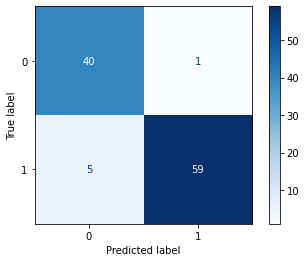

In [24]:
rfc = Pipeline(steps=[('scale', StandardScaler()), ('rfc', RandomForestClassifier(max_depth=5, random_state=0, criterion='gini'))])
rfc.fit(X_train_scaled, Y_train.ravel())
print_stats(rfc, x_test, y_test)

Finally we plot the ROC of the 4 trained models and show their evaluation metrics.

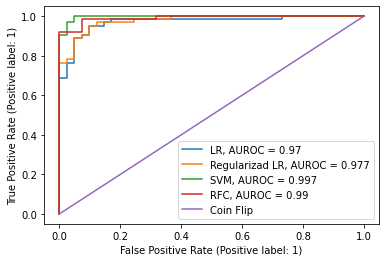

In [25]:
classifiers = [lr, lr_regul, best_svm, rfc]
roc_score = []
plt.figure()
ax = plt.gca()
for clf in classifiers:
    plot_roc_curve(clf, x_test, y_test, ax=ax)
    roc_score.append(np.round_(roc_auc_score(y_test, clf.predict_proba(x_test)[:,1]), decimals=3))
ax.plot(np.linspace(0,1,x_test.shape[0]),np.linspace(0,1,x_test.shape[0]))
plt.legend(('LR, AUROC = '+str(roc_score[0]),'Regularizad LR, AUROC = '+str(roc_score[1]),'SVM, AUROC = '+str(roc_score[2]),'RFC, AUROC = '+str(roc_score[3]),'Coin Flip'))
plt.show()

In [26]:
model_evaluation_metrics = pd.DataFrame({'Linear': return_stats(lr, x_test, y_test),
                                         'Linear Regulated': return_stats(lr_regul, x_test, y_test), 
                                         'Polynomial': return_stats(best_svm, x_test, y_test), 
                                         'Random Forest Classifier': return_stats(rfc, x_test, y_test)}).transpose()
display(model_evaluation_metrics)

,Log Loss,Hinge Loss,Sensitiviy,Specificity,Accuracy,F1,AUROC
Linear,0.223750,0.190476,0.890625,0.926829,0.904762,0.919355,0.969893
Linear Regulated,0.196267,0.190476,0.906250,0.902439,0.904762,0.920635,0.977134
Polynomial,0.083179,0.057143,0.968750,0.975610,0.971429,0.976378,0.996951
Random Forest Classifier,0.194552,0.114286,0.921875,0.975610,0.942857,0.951613,0.990473


In conclusion, we can observe both from the ROC and the evaluation metrics that non-linear models perform best on this dataset, and in particular a 3rd degree polynomial model returns very accurate evaluation metrics.

### Part 6
**Feature Selection**

### Part 7
**Data Separability Visualization**